# Pipeline for BIAPT lab EEG Preprocessing: 
#### inspired by: https://github.com/hoechenberger/pybrain_mne/
#### adapted by: Charlotte Maschke, Beatrice PDK and Victoria Sus
#### This pipeline uses MNE Python to preprocess EEG data: Plese go here: 
####                                https://mne.tools/stable/overview/index.html
####  for more documentation on MNE Python

## Some setup and import

In [1]:
import matplotlib
#import mne_bids
import pathlib
import mne
import os
import os.path as op
import sklearn 
from mne import viz

# interactive plotting functions.


from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
#import openneuro

#from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

# Ensure Matplotlib uses the Qt5Agg backend, 
# which is the best choice for MNE-Python's 
# interactive plotting functions.
matplotlib.use('Qt5Agg')

import matplotlib.pyplot as plt

### Which subject do you want to preprocess? 

In [2]:
ID = "004"
session = "07"
task = "post7"

In [3]:
raw_path = "./Data/coma_tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_eeg.mff".format(ID,session,ID,session,task)
raw_path

'./Data/coma_tacs/sub-004/ses-07/eeg/sub-004_ses-07_task-post7_eeg.mff'

## Load the raw data!

In [4]:
raw = mne.io.read_raw_egi(raw_path)
raw

Reading EGI MFF Header from C:\Users\VivoBook\Documents\GitHub\GitHub_remote_version\Data\coma_tacs\sub-004\ses-07\eeg\sub-004_ses-07_task-post7_eeg.mff...
    Reading events ...
    Assembling measurement info ...


<RawMff | signal1.bin, 129 x 103044 (412.2 s), ~178 kB, data not loaded>

## Resample the data to 250

In [5]:
if raw.info['sfreq'] != 250:
    raw = raw.resample(250)

### Keep only the EEG

In [6]:
# this is to load EEG. If you want to load other stuff please refer to the website documetation
eeg = raw.pick_types(eeg = True)
print('Number of channels in EEG:')
len(eeg.ch_names)

Number of channels in EEG:


129

## Filter the data

In [7]:
# load actual data into system (before it was only metadata)
eeg.load_data()
#eeg.load_data()

# filter the data between 1 to 55 Hz
eeg_filtered = eeg.filter(l_freq=1, h_freq = 55)# we needed to lower the low_pass to 50 because of the presence of a weird machine artifact
#eeg_filtered = eeg.filter(l_freq=1, h_freq = 55) 

# notch filter the data for freq =60
eeg_notch = eeg_filtered.copy().notch_filter(freqs= 60)
#eeg_notch = eeg_filtered.notch_filter(freqs=60)


Reading 0 ... 103043  =      0.000 ...   412.172 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 825 samples (3.300 sec)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upp

In [8]:
%matplotlib qt
viz.plot_raw_psd(eeg_notch, exclude = ['E129'], fmax = 70)
if not os.path.exists('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}'.format(ID,session,task)) :
    os.makedirs('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}'.format(ID,session,task))
plt.savefig('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_PSD_raw_filtered.png'.format(ID,session,task,ID,session,task))

Effective window size : 8.192 (s)


## Crop the data

Depending on the data, we may need to crop the begining or/and the end

Using matplotlib as 2D backend.


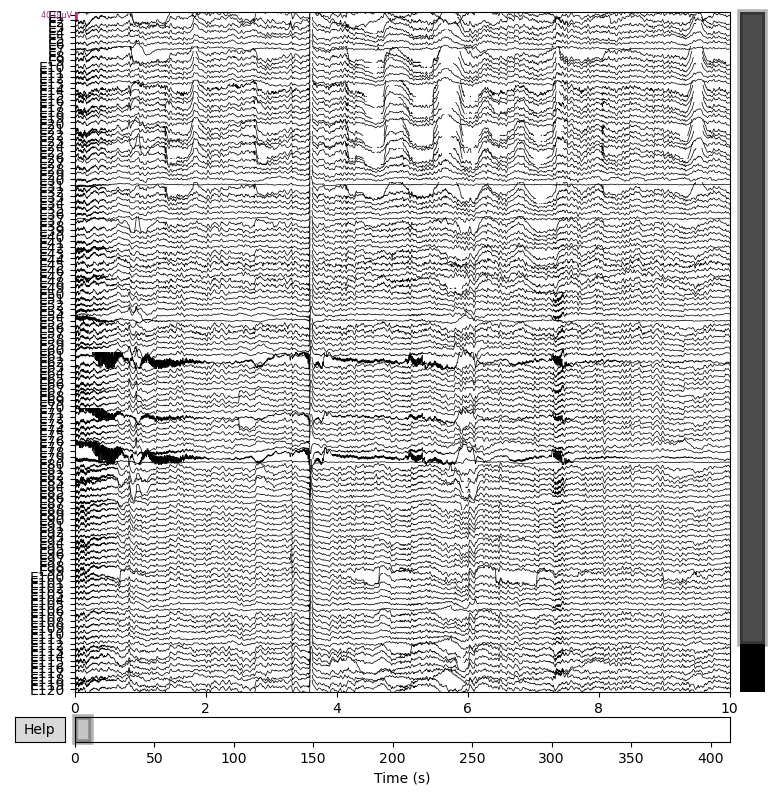

Channels marked as bad: none


In [9]:
eeg_notch.plot(duration=10, n_channels=120, title='raw')

Select if begining and end should be cropped and adapt next line accordingly

In [10]:
eeg_cropped= eeg_notch.crop(tmin=2.0, tmax=410.0)

In [ ]:
eeg_cropped.plot(duration=10, n_channels=120,title='cropped')

In [ ]:
eeg_cropped

## Visualize raw data to identify bad channels

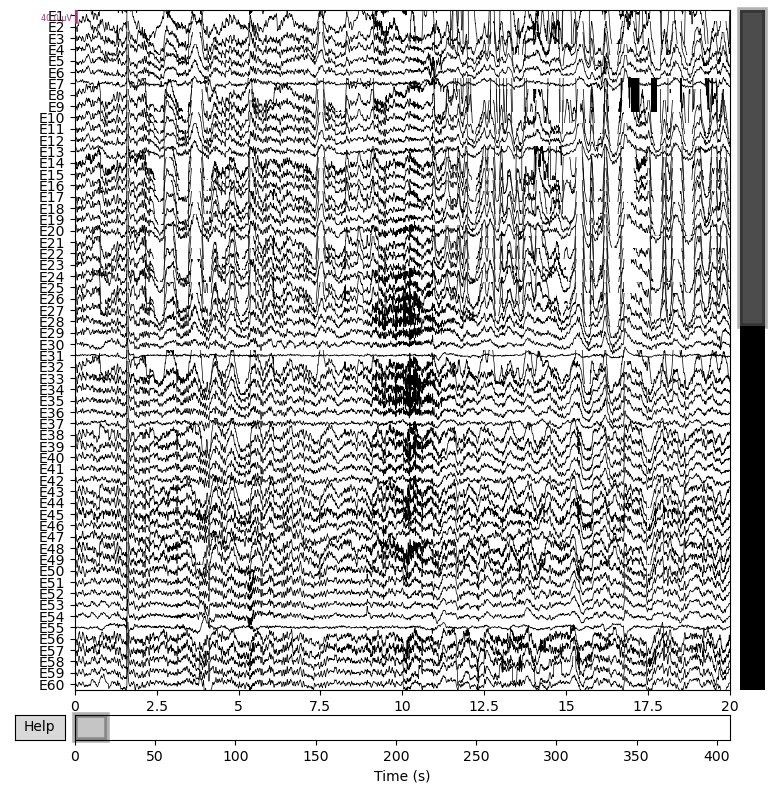

Channels marked as bad: ['E2', 'E8', 'E9', 'E31', 'E80', 'E55', 'E107']


In [11]:
eeg_cropped.plot(n_channels=60, duration=20)

In [11]:
eeg_cropped

<RawMff | signal1.bin, 129 x 97501 (390.0 s), ~96.1 MB, data loaded>

Verify if labelled correctly

In [12]:
marked_bad = eeg_cropped.info['bads']
marked_bad

['E2', 'E8', 'E9', 'E31', 'E80', 'E55', 'E107']

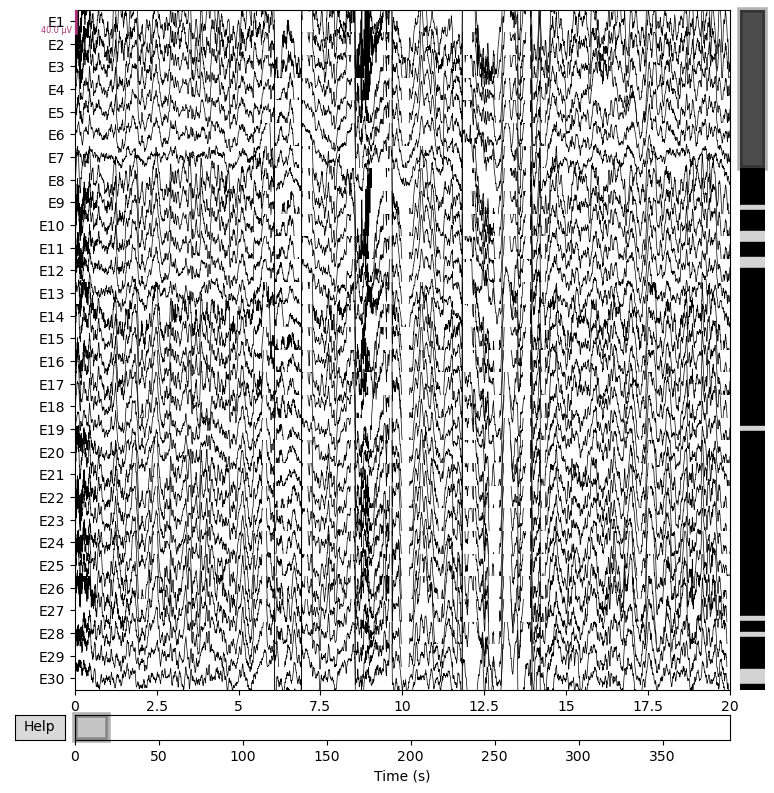

Channels marked as bad: ['E38', 'E43', 'E44', 'E48', 'E49', 'E80', 'E116', 'E119', 'E126', 'E127', 'E128']


In [13]:
eeg_cropped.plot(n_channels =30, duration=20)

In [13]:
# save in a txt
if not os.path.exists('./eeg_output2/coma_tacs/sub-{}/ses-{}/eeg'.format(ID,session)) :
    os.makedirs('./eeg_output2/coma_tacs/sub-{}/ses-{}/eeg'.format(ID,session))
with open('./eeg_output2/coma_tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_marked_bads.json'.format(ID,session,ID,session,task), 'w') as outfile:
    outfile.write("\n".join(marked_bad))


## Remove bad channels

In [14]:
eeg_cropped_removed = eeg_cropped.copy().drop_channels(eeg_cropped.info['bads'])
#eeg_cropped_removed.plot(n_channels=60, duration=20, title='removed')
#eeg_cropped.plot(n_channels=120, duration=20, title='raw')


In [15]:
eeg_cropped_removed

<RawMff | signal1.bin, 122 x 102001 (408.0 s), ~95.1 MB, data loaded>

In [17]:
#eeg_interpol = eeg_cropped.copy().interpolate_bads()
#eeg_interpol.plot(n_channels=120, duration=20, title='interpol')
#eeg_cropped.plot(n_channels=120, duration=20, title='raw')


# Make epochs of 10 s

In [16]:
epochs = mne.make_fixed_length_epochs(eeg_cropped_removed, duration = 10, overlap=0)

Not setting metadata
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated


In [17]:
epochs  #verify initial number

<Epochs |  40 events (good & bad), 0 - 9.996 sec, baseline off, ~172 kB, data not loaded,
 '1': 40>

Loading data for 33 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...


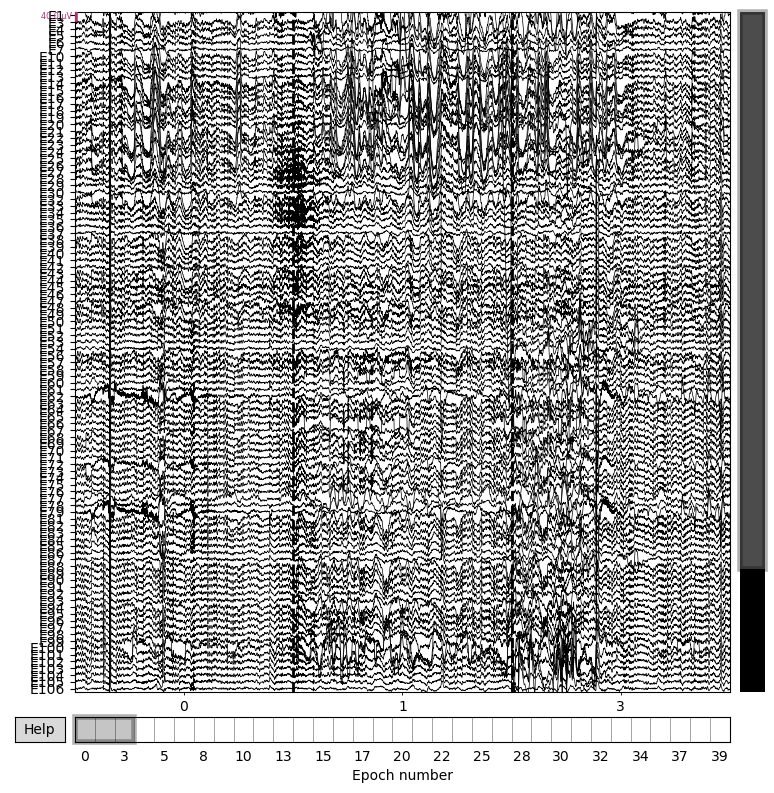

Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Dropped 0 epochs: 
Channels marked as bad: none


In [21]:
epochs.plot(n_epochs=3, n_channels=100, scalings=20e-6)

In [19]:
epochs #verify how many are left

<Epochs |  33 events (all good), 0 - 9.996 sec, baseline off, ~172 kB, data not loaded,
 '1': 33>

In [22]:
epochs.save(("./eeg_output2/coma_tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_{}_eeg.fif".format(ID, session, ID, session, task, 'epoch')),overwrite=True)


Overwriting existing file.
Loading data for 1 events and 2500 original time points ...
Loading data for 33 events and 2500 original time points ...


C:\Users\VivoBook\AppData\Local\Temp\ipykernel_9028\3249607757.py:1: RuntimeWarning: This filename (./eeg_output2/coma_tacs/sub-004/ses-07/eeg/sub-004_ses-07_task-post7_epoch_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(("./eeg_output2/coma_tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_{}_eeg.fif".format(ID, session, ID, session, task, 'epoch')),overwrite=True)


# RUN ICA

## Manual selection of ICA components

In [ ]:
# pick some channels that clearly show blinks
#eog_channels = [‘E8’ ,‘E14’, ‘E21’, ‘E25’, ‘E126’, ‘E126’, ‘E127’, ‘E128’] 

In [23]:
#eeg_avg_ref.info['EOG channels']
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

ica = ICA(n_components=15, max_iter='auto', random_state=97)
ica.fit(epochs)

Fitting ICA to data using 122 channels (please be patient, this may take a while)
Loading data for 33 events and 2500 original time points ...
Selecting by number: 15 components
Loading data for 33 events and 2500 original time points ...
Fitting ICA took 4.4s.


<ICA | epochs decomposition, method: fastica (fit in 28 iterations on 82500 samples), 15 ICA components explaining 83.1 % of variance (122 PCA components available), channel types: eeg, no sources marked for exclusion>

Loading data for 33 events and 2500 original time points ...
Not setting metadata
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


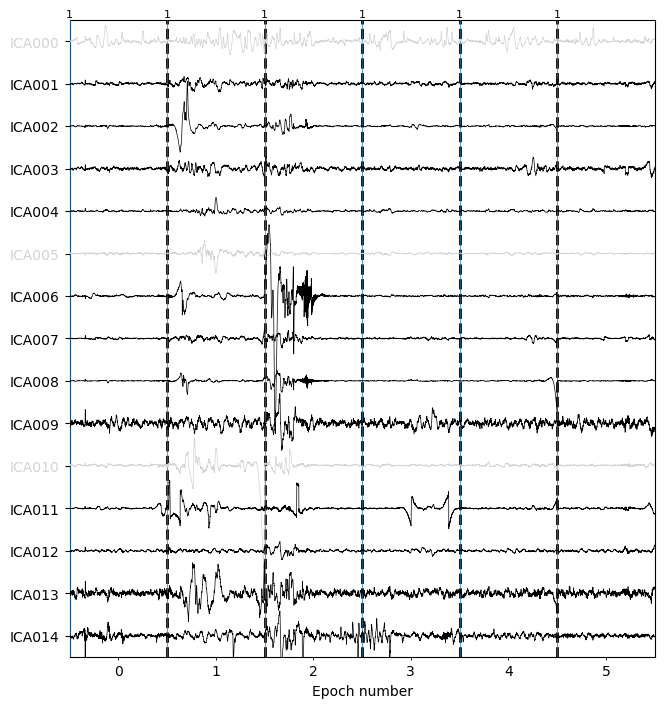

In [36]:
ica.plot_sources(epochs, show_scrollbars=False, stop = 6)


In [35]:
ica.plot_components()

[<MNEFigure size 975x731 with 15 Axes>]

In [37]:
ica

<ICA | epochs decomposition, method: fastica (fit in 28 iterations on 82500 samples), 15 ICA components explaining 83.1 % of variance (122 PCA components available), channel types: eeg, 3 sources marked for exclusion>

In [38]:
ica.plot_properties(epochs, picks=ica.exclude)

Loading data for 33 events and 2500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [ ]:
# blinks
#ica.plot_overlay(epochs, start =50, stop = 60)
#ica.plot_overlay(eeg_avg_ref, exclude=[0,1,2,3],start = 30*250, stop = 40*250)

Double check which component to remove: 

In [39]:
ica.exclude

[0, 5, 11]

Remove component definetely

In [40]:
epochs.load_data()
eeg_postica= ica.apply(epochs.copy())


Loading data for 33 events and 2500 original time points ...
Applying ICA to Epochs instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 122 PCA components


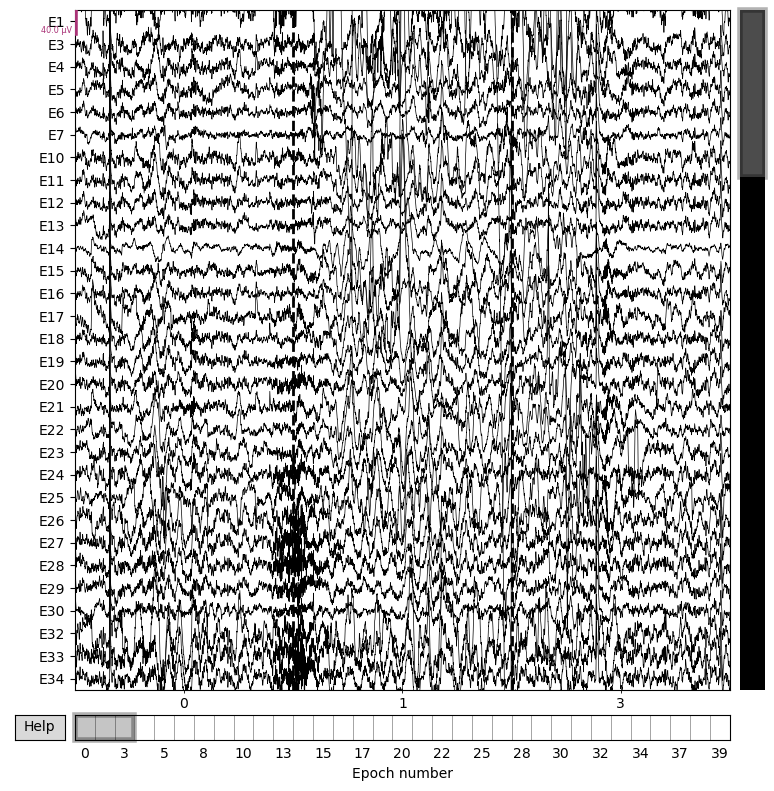

Dropped 0 epochs: 
Channels marked as bad: none
Dropped 0 epochs: 
Channels marked as bad: none


In [41]:
# PLot to compare both signals pre and post ICA
epochs.plot(title='raw', n_epochs=3, n_channels=30, scalings=20e-6)
eeg_postica.plot(title='ICA correction', n_epochs=3, n_channels=30, scalings=20e-6)

In [ ]:
eeg_postica

## Average Reference the data

In [42]:
# use the average of all channels as reference
eeg_avg_ref = eeg_postica.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


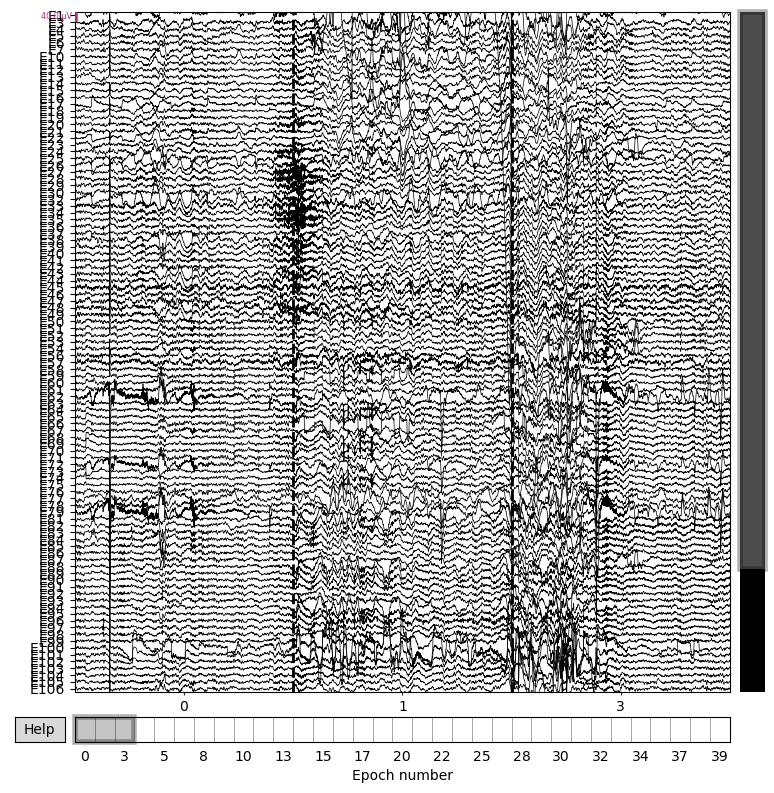

C:\Users\VivoBook\anaconda3\lib\site-packages\mne\viz\_mpl_figure.py:1779: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _cols = np.array([self.mne.epoch_color_bad,
C:\Users\VivoBook\anaconda3\lib\site-packages\mne\viz\_mpl_figure.py:1779: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _cols = np.array([self.mne.epoch_color_bad,
C:\Users\VivoBook\anaconda3\lib\site-packages\mne\viz\_mpl_figure.py:1779: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different len

Dropped 10 epochs: 6, 7, 8, 9, 12, 13, 15, 17, 18, 19
Channels marked as bad: none


In [44]:
eeg_avg_ref.plot(title='Avg ref', n_epochs=3, n_channels=100, scalings=20e-6)

In [45]:
%matplotlib tk
eeg_avg_ref.plot_psd(fmax=55)
if not os.path.exists('./out_figures/coma_tacs/sub-{}/ses-{}/task-{}'.format(ID,session,task)) :
    os.makedirs('./out_figures/coma_tacs/sub-{}/ses-{}/task-{}'.format(ID,session,task))
plt.savefig('./out_figures/coma_tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_PSD_avg_ref.png'.format(ID,session,task,ID,session,task))

    Using multitaper spectrum estimation with 7 DPSS windows


In [ ]:
eeg_avg_ref.info

## Identify remaining  bad channels

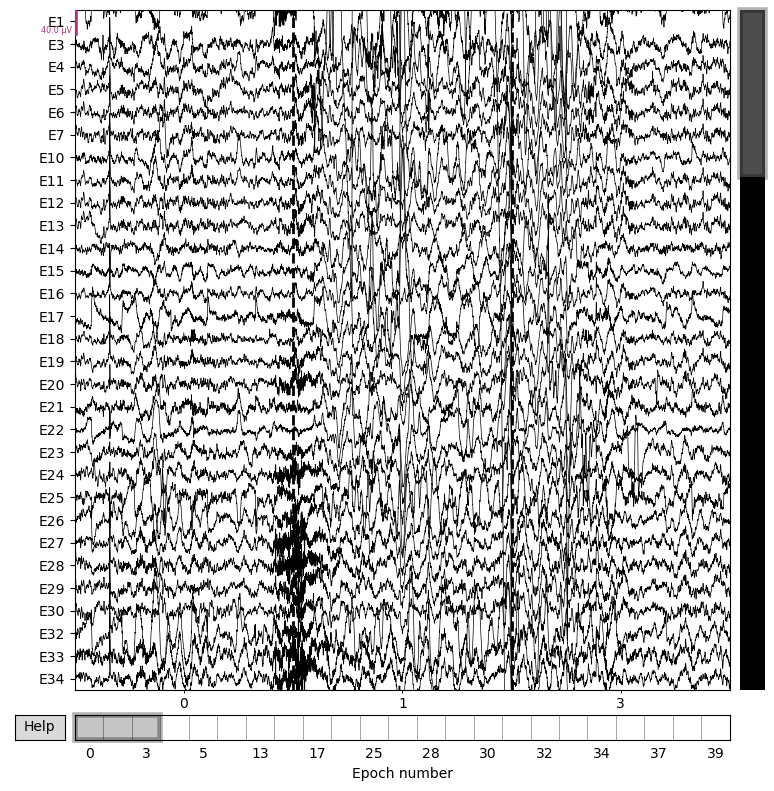

Dropped 0 epochs: 
Channels marked as bad: none


In [49]:
eeg_avg_ref.plot(title='Identify remaining bad channels', n_epochs=3, n_channels=30, scalings=20e-6)

## Remove Non-Brain Electrodes 

In [50]:
non_brain_el = ['E127', 'E126', 'E17', 'E21', 'E14', 'E25', 'E8', 'E128', 'E125', 'E43', 'E120', 'E48', 
                'E119', 'E49', 'E113', 'E81', 'E73', 'E88', 'E68', 'E94', 'E63', 'E99', 'E56', 'E107' ]

#only add non-brain channels if not already part of noisy channels
for e in non_brain_el: 
    if e not in marked_bad :
        eeg_avg_ref.info['bads'].append(e)


In [51]:
print(eeg_avg_ref.info['bads'])

['E127', 'E126', 'E17', 'E21', 'E14', 'E25', 'E128', 'E125', 'E43', 'E120', 'E48', 'E119', 'E49', 'E113', 'E81', 'E73', 'E88', 'E68', 'E94', 'E63', 'E99', 'E56']


In [52]:
# remove non-brain channels
eeg_brainonly = eeg_avg_ref.copy().drop_channels(eeg_avg_ref.info['bads'])

## Identify remaining bad epochs

In [55]:
eeg_brainonly  #verify initial number

<Epochs |  23 events (all good), 0 - 9.996 sec, baseline off, ~44.0 MB, data loaded,
 '1': 23>

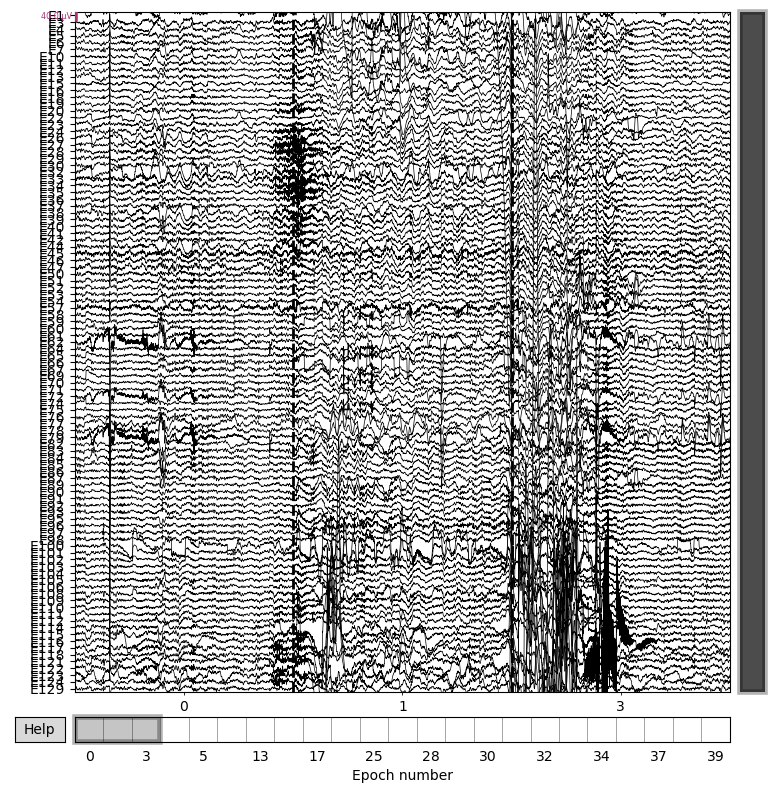

C:\Users\VivoBook\anaconda3\lib\site-packages\mne\viz\_mpl_figure.py:1779: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _cols = np.array([self.mne.epoch_color_bad,
C:\Users\VivoBook\anaconda3\lib\site-packages\mne\viz\_mpl_figure.py:1779: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _cols = np.array([self.mne.epoch_color_bad,
C:\Users\VivoBook\anaconda3\lib\site-packages\mne\viz\_mpl_figure.py:1779: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different len

C:\Users\VivoBook\anaconda3\lib\site-packages\mne\viz\_mpl_figure.py:1779: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _cols = np.array([self.mne.epoch_color_bad,
C:\Users\VivoBook\anaconda3\lib\site-packages\mne\viz\_mpl_figure.py:1779: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _cols = np.array([self.mne.epoch_color_bad,
C:\Users\VivoBook\anaconda3\lib\site-packages\mne\viz\_mpl_figure.py:1779: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different len

Dropped 7 epochs: 1, 2, 10, 11, 14, 15, 16
Channels marked as bad: none


In [57]:
eeg_brainonly.plot(title='brain only', n_epochs=3, n_channels=100, scalings=20e-6)

In [58]:
eeg_brainonly #how many left

<Epochs |  16 events (all good), 0 - 9.996 sec, baseline off, ~30.7 MB, data loaded,
 '1': 16>

## Save final non brain data

In [ ]:
eeg_brainonly.save("./eeg_output2/coma_tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_{}_eeg.fif".format(ID, session, ID, session, task, 'nonbrainfiltered_noncut'), overwrite=True)
#ici changer pour le sauver dans derivatives, dossier clean (avec un readme expliquant le cleaning) et le fichier sous le bids format

Verify psd

In [ ]:
%matplotlib qt
epochs.plot_psd(fmax=55)
plt.savefig('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_PSD_brainonly.png'.format(ID,session,task,ID,session,task))